In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import haiku as hk
from jaxtyping import install_import_hook

import jax.numpy as jnp
from jax.example_libraries import optimizers
import jax

from tqdm import tqdm, trange

from jax_bayes.utils import confidence_bands
from jax_bayes.mcmc import (
    langevin_fns,
    mala_fns,
    hmc_fns,
)

# with install_import_hook("gpjax", "beartype.beartype"):
#     import gpjax as gpx
from jax import config

config.update("jax_enable_x64", False)

from jax import jit
import jax.numpy as jnp
import optax as ox

    
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

In [2]:
notebooks_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebooks_dir, os.pardir))
print(f"Project root directory: {project_root}")

# Add the project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    import utils.plots as plots
    import utils.metrics as metrics
    print("Import successful")
except ImportError as e:
    print(f"Error importing module: {e}")

Project root directory: /Users/aleynakara/Documents/ML4RG_Group1
Import successful


In [3]:
processed_data_path = f"{project_root}/data/processed_data_kmer_fat.pkl"
data_df = pd.read_pickle(processed_data_path)
data_df

,species,species_id,upstream200,TTA,TAC,ACG,CGT,GTT,TTT,TAG,...,CCT,CGC,CGG,GGG,CCC,CCG,stress,stress_name,is_normalized,stress_id
0,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.611770,mig,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.536547,as,False,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.515880,oss,False,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.040466,ns,False,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.056525,oxs,False,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067401,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,...,2.0,1.0,4.0,1.0,1.0,1.0,0.120647,bs,True,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2067402,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,...,2.0,1.0,4.0,1.0,1.0,1.0,-0.480353,sp,True,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2067403,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,...,2.0,1.0,4.0,1.0,1.0,1.0,0.275017,tm,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2067404,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,...,2.0,1.0,4.0,1.0,1.0,1.0,-0.051995,li,True,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [4]:
df = data_df[data_df["is_normalized"] == True]
df.drop(columns=["is_normalized", "upstream200"], inplace=True)
# drop the conditions that miss values for more than two speices
# df = df[df['stress_name'] != 'bs']
# df = df[df['stress_name'] != 'vic']
# # drop the species that misses values for more than two conditions
# df = df[df['species'] != "SSUIS"]
df.reset_index(drop=True, inplace=True)
df

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_76686/3939428512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["is_normalized", "upstream200"], inplace=True)


,species,species_id,TTA,TAC,ACG,CGT,GTT,TTT,TAG,AGA,...,GTA,CCT,CGC,CGG,GGG,CCC,CCG,stress,stress_name,stress_id
0,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.611770,mig,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.536547,as,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.515880,oss,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040466,ns,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056525,oxs,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033698,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,2.0,1.0,4.0,1.0,1.0,1.0,0.120647,bs,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1033699,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,2.0,1.0,4.0,1.0,1.0,1.0,-0.480353,sp,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1033700,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,2.0,1.0,4.0,1.0,1.0,1.0,0.275017,tm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1033701,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,2.0,1.0,4.0,1.0,1.0,1.0,-0.051995,li,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [5]:
stress_names = df["stress_name"].unique()
# Create a color palette with seaborn for dark background
palette = sns.color_palette("Set2", len(stress_names))

# # Create a color mapping dictionary
# color_mapping = {value: palette[i] for i, value in enumerate(stress_names)}

color_mapping = {
    "as": "#dbce9d",
    "ns": "#c02b33",
    "oxs": "#4d9b67",
    "sp": "#3f3fbc",
    "vic": "#fefb46",
    "tm": "#42db24",
    "oss": "#2fa3d4",
    "nd": "#E3FD0A",
    "li": "#FE6800",
    "bs": "#9E8BFF",
    "mig": "#1C42FF",
}

In [6]:
def prepare_data(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
    normalize: bool = True,
) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    """
    Prepare the data for Bayesian regression.

    Parameters:
    df (pd.DataFrame): The original data as a pandas DataFrame.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    X_train (pd.DataFrame): Training set features.
    X_test (pd.DataFrame): Testing set features.
    y_train (pd.DataFrame): Training set labels.
    y_test (pd.DataFrame): Testing set labels.
    """
    # Extract labels
    labels = df[["species", "stress_name"]]
    # Combine labels for stratified splitting
    stratify_labels = labels.apply(lambda x: f"{x[0]}", axis=1)

    outputs = jnp.array(df["stress"].to_numpy(), jnp.float32)

    # Extract and standardize features
    feature_columns = [col for col in df.columns if len(col) == 3]

    features = df[feature_columns]
    features_standardized = (features - features.mean()) / features.std()
    features_standardized = jnp.array(features_standardized.to_numpy(), jnp.float32)
    one_hot_species = jnp.array(np.vstack(df.loc[:, "species_id"]), dtype=jnp.float32)
    one_hot_stress = jnp.array(np.vstack(df.loc[:, "stress_id"]), dtype=jnp.float32)
    inputs = jnp.concatenate(
        (features_standardized, one_hot_species, one_hot_stress), axis=1
    )

    X_train, X_test, y_train, y_test = train_test_split(
        inputs,
        outputs,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_labels,
    )

    # Standardize the output (stress) values
    y_mean = y_train.mean()
    y_std = y_train.std()

    if normalize:
        y_train = (y_train - y_mean) / y_std
        y_test = (y_test - y_mean) / y_std

        y_train = jnp.array(y_train, jnp.float32)
        y_test = jnp.array(y_test, jnp.float32)

    return (X_train, y_train), (X_test, y_test), y_mean, y_std

In [7]:
xy_train, xytest, y_mean, y_std = prepare_data(df)
(x_train, y_train), (x_test, y_test) = xy_train, xytest

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_76686/2423395328.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stratify_labels = labels.apply(lambda x: f"{x[0]}", axis=1)


In [8]:
# import functools
# import time

# import jax
# from jax import numpy as jnp
# from jax import random
# import bartz



# n_tree = 50
# keys = list(random.split(jax.random.key(202404161853), 2))
# start = time.perf_counter()
# bart = bartz.BART.gbart(jnp.array(x_train.T, dtype=jnp.float32),
#                         jnp.array(y_train, dtype=jnp.float32),
#                         ntree=n_tree,
#                         printevery=10, seed=keys.pop())
#                         #max_depth=3, nu=0.5, verbose=True)
# end = time.perf_counter()

In [9]:
# import pickle

# bart = pickle.load(open("bart_200.pkl", "rb"))

In [10]:
# yhat_test_mean = bart.predict(x_test.T).mean(axis=0)
# rmse = jnp.sqrt(jnp.mean(jnp.square(yhat_test_mean - y_test)))
# print(f'RMSE: {rmse:#.2g}')
# print(f'r2: {metrics.r2_score(y_test, yhat_test_mean)}')
# print(f'sigma: {jnp.sqrt(jnp.mean(bart.sigma ** 2)):#.2g}')
# print(f'time: {(end - start) / 60:#.2g} min')

In [11]:
df['species_arg_max'] = df['species_id'].apply(lambda x: np.argmax(x))
df['stress_arg_max'] = df['stress_id'].apply(lambda x: np.argmax(x))

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_76686/1134582878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['species_arg_max'] = df['species_id'].apply(lambda x: np.argmax(x))
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_76686/1134582878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stress_arg_max'] = df['stress_id'].apply(lambda x: np.argmax(x))


In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# predictions = bart.predict(x_test.T)
# uncertainty = predictions.var(axis=0)
# predictions = predictions.mean(axis=0)

# # Unique classes for coloring
# unique_classes = df['species_arg_max'].unique()
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

In [56]:
# trained_predictions = bart.predict(x_train.T)

# print(metrics.mean_absolute_error(y_train, trained_predictions))
# print(metrics.root_mean_squared_error(y_train, trained_predictions))
# print(metrics.r2_score(y_train, trained_predictions))
# print(metrics.adjusted_r2_score(y_train, trained_predictions, x_test.shape[0], x_test.shape[1]))
# print(metrics.mean_absolute_percentage_error(y_train, trained_predictions))
# print(metrics.mean_bias_deviation(y_train, trained_predictions))
# print(metrics.explained_variance_score(y_train, trained_predictions))

0.61803406
0.9305007
-864.83154
-865.27155
624.49963
-3.130455e-05
0.13416839


In [57]:
# print(metrics.mean_squared_error(y_test, predictions))

0.8714348


In [13]:
# species2indices = defaultdict(list)
# stress2indices = defaultdict(list)
# num_species = df['species_arg_max'].max() + 1
# num_stress = df['stress_arg_max'].max() + 1

# for i, x in enumerate(x_test):
#     stress_argmax = x[-num_stress:].argmax()
#     species_argmax = x[-(num_species + num_stress): -num_stress].argmax()
#     print(species_argmax, stress_argmax)
#     species2indices[str(species_argmax)].append(i)
#     stress2indices[str(stress_argmax)].append(i)

In [14]:
# # Plotting

# sampled_indices = {k:np.random.choice(v, 1) for k, v in species2indices.items()}

# vs = []
# ks = []
# stds = []

# for k, indices in sampled_indices.items():
#     for i in indices:
#         print(predictions[i], uncertainty[i])
#         vs.append(predictions[i])
#         stds.append(uncertainty[i])
#         ks.append(int(k))

# output_sorted_indices = np.argsort(np.array(vs))
# vs = np.array(vs)[output_sorted_indices]
# ks = np.array(ks)[output_sorted_indices]    
# stds = np.array(stds)[output_sorted_indices]

# plt.figure(figsize=(10, 6))    

# for i, (k, v, std) in enumerate(zip(ks, vs, stds)):
#     #mask = classes == cls
#     #plt.scatter(cur_indices, cur_y, label=cls, color=color)
#     plt.scatter(i, v, color=colors[int(k)])
#     #plt.plot(cur_indices, predictions[cur_indices], color=color)
#     print(v-std, v+std)
#     print(std)
#     plt.fill_between(np.array([i]), np.array([v - std]), np.array([v+std]), color=colors[int(k)], alpha=1)


# plt.xlabel('X')
# plt.ylabel('y')
# plt.title('Regression Predictions with Uncertainty for Different Classes')
# plt.legend()
# plt.show()

In [15]:
# # Plotting

# sampled_indices = {k:v for k, v in species2indices.items()}

# vs = []
# ks = []
# stds = []
# ys = []

# for k, indices in sampled_indices.items():
#     for i in indices:
#         vs.append(predictions[i])
#         stds.append(uncertainty[i])
#         ks.append(int(k))
#         ys.append(y_test[i])

# output_sorted_indices = np.argsort(np.array(vs))
# vs = np.array(vs)[output_sorted_indices]
# ks = np.array(ks)[output_sorted_indices]    
# stds = np.array(stds)[output_sorted_indices]
# ys = np.array(ys)[output_sorted_indices]
# xs = np.linspace(0, 0.5, len(stds))

# plt.figure(figsize=(10, 6))    


# # plt.scatter(xs, vs, color=colors[int(k)], marker='.')
# plt.plot(xs, vs)
# plt.fill_between(xs, vs-stds, vs+stds, color=colors[int(k)], alpha=0.2)


# plt.ylabel('TPM')
# plt.xticks([])
# plt.title('Regression Predictions with Uncertainty')
# plt.legend()
# save_path = f"{project_root}/figures/bart_uncertainty_regression.png"
# plt.savefig(save_path, dpi=300)
# plt.show()

In [16]:
# save_path = f"{project_root}/figures/bartz_scatter.png"
# plots.plot_predictions_vs_labels(vs, ys, path=save_path)

In [17]:
df

,species,species_id,TTA,TAC,ACG,CGT,GTT,TTT,TAG,AGA,...,CGC,CGG,GGG,CCC,CCG,stress,stress_name,stress_id,species_arg_max,stress_arg_max
0,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,-1.611770,mig,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",27,3
1,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,-0.536547,as,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",27,0
2,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,-0.515880,oss,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",27,6
3,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.040466,ns,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",27,5
4,STRPN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,3.0,1.0,1.0,4.0,21.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.056525,oxs,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",27,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033698,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,4.0,1.0,1.0,1.0,0.120647,bs,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",19,1
1033699,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,4.0,1.0,1.0,1.0,-0.480353,sp,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",19,8
1033700,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,4.0,1.0,1.0,1.0,0.275017,tm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",19,9
1033701,NGON,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,...,1.0,4.0,1.0,1.0,1.0,-0.051995,li,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",19,2


In [18]:
# import pickle
# with open(f'bart_{n_tree}.pkl', 'wb') as f:
#     pickle.dump(bart, f)

In [19]:
def create_batches(x, y, batch_size):
    """
    Generates batches from the given data.

    Args:
    - x (numpy.ndarray): The input features.
    - y (numpy.ndarray): The corresponding labels.
    - batch_size (int): The size of each batch.

    Yields:
    - A tuple (x_batch, y_batch) containing a batch of input features and labels.
    """
    # Shuffle the data (important for training)
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    for start_idx in range(0, x.shape[0] - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x[excerpt], y[excerpt]


train_batch_size = 1024
test_batch_size = 1024

In [20]:
def remove_outliers_iqr(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    indices = np.where((data >= lower_bound) & (data <= upper_bound))[0]
    filtered_data = data[indices]
    return filtered_data, indices


def get_indices_of_values(original_data, values):
    indices = [np.where(original_data == value)[0] for value in values]
    return indices

In [21]:
def net_fn(x):

    mlp = hk.Sequential(
        [
            hk.Linear(
                32,
                w_init=hk.initializers.RandomNormal(stddev=1),
                b_init=hk.initializers.RandomNormal(stddev=1),
            ),
            jax.nn.relu,
            hk.Linear(
                1,
                w_init=hk.initializers.RandomNormal(stddev=1),
                b_init=hk.initializers.RandomNormal(stddev=1),
            ),
        ]
    )

    return mlp(x)


# def mlp(x):
#     _mlp = hk.nets.MLP(
#         output_sizes=[32, 16, 1],
#         w_init=hk.initializers.RandomNormal(stddev=1),
#         b_init=hk.initializers.RandomNormal(stddev=1),
#         activation=jax.nn.relu,
#         activate_final=False,
#     )

#     return _mlp(x) #, dropout_rate=0.5, rng=jax.random.PRNGKey(42))

# def net_fn(x):

#     mlp = hk.Sequential(
#         [
#             hk.Linear(
#                 32,
#                 w_init=hk.initializers.RandomNormal(stddev=1),
#                 b_init=hk.initializers.RandomNormal(stddev=1),
#             ),
#             hk.BatchNorm(True, True, 0.9),
#             jax.nn.relu,
#             hk.Linear(
#                 16,
#                 w_init=hk.initializers.RandomNormal(stddev=1),
#                 b_init=hk.initializers.RandomNormal(stddev=1),
#             ),
#             hk.BatchNorm(True, True, 0.9),
#             jax.nn.relu,
#             hk.Linear(
#                 1,
#                 w_init=hk.initializers.RandomNormal(stddev=1),
#                 b_init=hk.initializers.RandomNormal(stddev=1),
#             ),
#         ]
#     )

#     return mlp(x)

# def net_fn(x):
#     x = hk.Linear(32,
#                   w_init=hk.initializers.RandomNormal(stddev=1),
#                   b_init=hk.initializers.RandomNormal(stddev=1))(x)
#     # x = hk.BatchNorm(True, True, 0.9)(x)
#     x = jax.nn.relu(x)
#     x = hk.Linear(16,
#                   w_init=hk.initializers.RandomNormal(stddev=1),
#                   b_init=hk.initializers.RandomNormal(stddev=1))(x)
#     # x = hk.BatchNorm(True, True, 0.9)(x)
#     x = jax.nn.relu(x)
#     x = hk.Linear(1,
#                   w_init=hk.initializers.RandomNormal(stddev=1),
#                   b_init=hk.initializers.RandomNormal(stddev=1))(x)
#     return x


In [22]:
# Remove outliers
y_filtered, indices = remove_outliers_iqr(y_test)

In [23]:
lr = 2e-4
reg = 0.0
lik_var = 0.5

net_nn = hk.transform(net_fn)
opt_init, opt_update, opt_get_params = optimizers.adam(lr)
# initialization
params = net_nn.init(jax.random.PRNGKey(42), x_train[0])
print(params)
opt_state = opt_init(params)

y_inital_nn = net_nn.apply(params, None, x_test).flatten()
initial_filtered_ynn = y_inital_nn[indices]

{'linear': {'w': Array([[-1.2896041 , -1.3383764 ,  0.4013733 , ...,  0.30736277,
        -0.19272882,  0.17045741],
       [-2.1650248 , -0.32355526,  1.3618603 , ..., -0.20433354,
        -1.5905119 , -1.2900683 ],
       [ 1.1701404 ,  2.1630504 , -1.4179889 , ..., -1.1794224 ,
        -0.11124949,  1.7299973 ],
       ...,
       [-0.24275288, -1.0693088 ,  0.58990675, ...,  0.04479881,
        -0.10647915,  0.35152936],
       [-1.092278  , -0.20604067,  0.05479459, ...,  1.6124462 ,
         0.17901725, -2.2678616 ],
       [ 2.1185267 , -0.38666824,  0.87078893, ..., -0.7414473 ,
        -1.0582051 , -1.503682  ]], dtype=float32), 'b': Array([ 1.3566406 , -0.08489787,  0.8275152 , -0.23243172, -0.58480173,
        0.73040223, -1.0203536 , -0.52484125,  0.2737582 , -0.8491826 ,
        1.5279495 ,  0.0337434 , -1.0591152 , -0.80416787,  1.1271383 ,
        1.43529   ,  0.51245207, -0.9346318 ,  0.18146785, -0.37733966,
       -0.17481445,  1.2927204 , -0.13155659, -0.73364973, -0

In [24]:
metrics.r2_score(y_inital_nn, y_test)

Array(-0.60864794, dtype=float32)

In [25]:
def logprior(params, weight=0.0):
    return -weight * sum(
        jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)
    )

def logprob(params, xy):
    """log posterior logP(params | xy), assuming
    P(params) ~ N(0,eta)
    P(y|x, params) ~ N(f(x;params), lik_var)
    """
    x, y = xy
    preds = net_nn.apply(params, None, x)
    log_prior = logprior(params, 0.0)
    # log_lik = - jnp.sum(jnp.square(preds - y)) / lik_var
    log_lik = -jnp.sum(jnp.abs(preds - y))
    return log_lik + log_prior

# minimize the - logprob to find MAP
loss = lambda params, xy: -logprob(params, xy)

In [26]:
@jax.jit
def train_step(i, opt_state, batch):
    params = opt_get_params(opt_state)
    dx = jax.grad(loss)(params, batch)
    opt_state = opt_update(i, dx, opt_state)
    return opt_state

# do the optimization
num_epochs = 10
np.random.seed(0)
for epoch in trange(num_epochs):
    running_loss = 0.0
    for i, (x, y) in enumerate(create_batches(x_train, y_train, train_batch_size)):
        xy_train = (x, y)
        opt_state = train_step(epoch, opt_state, xy_train)
        params = opt_get_params(opt_state)
        cur_loss = loss(params, xy_train)
        running_loss += cur_loss
    print(f"epoch = {epoch + 1} | train loss = {running_loss:.3f}")

 10%|█         | 1/10 [00:03<00:27,  3.04s/it]

epoch = 1 | train loss = 15570159616.000


 20%|██        | 2/10 [00:05<00:21,  2.63s/it]

epoch = 2 | train loss = 11665988608.000


 30%|███       | 3/10 [00:07<00:17,  2.48s/it]

epoch = 3 | train loss = 10168280064.000


 40%|████      | 4/10 [00:10<00:15,  2.52s/it]

epoch = 4 | train loss = 9090525184.000


 50%|█████     | 5/10 [00:12<00:12,  2.58s/it]

epoch = 5 | train loss = 8221497344.000


 60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

epoch = 6 | train loss = 7495230976.000


 70%|███████   | 7/10 [00:18<00:07,  2.56s/it]

epoch = 7 | train loss = 6877760000.000


 80%|████████  | 8/10 [00:20<00:05,  2.60s/it]

epoch = 8 | train loss = 6347493888.000


 90%|█████████ | 9/10 [00:23<00:02,  2.57s/it]

epoch = 9 | train loss = 5888196608.000


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

epoch = 10 | train loss = 5486976512.000


In [27]:
# Remove outliers
y_nn = net_nn.apply(params, None, x_test).flatten()
y_filtered_nn = y_nn[indices]

In [28]:
metrics.r2_score(y_nn, y_test)

Array(-0.01588202, dtype=float32)

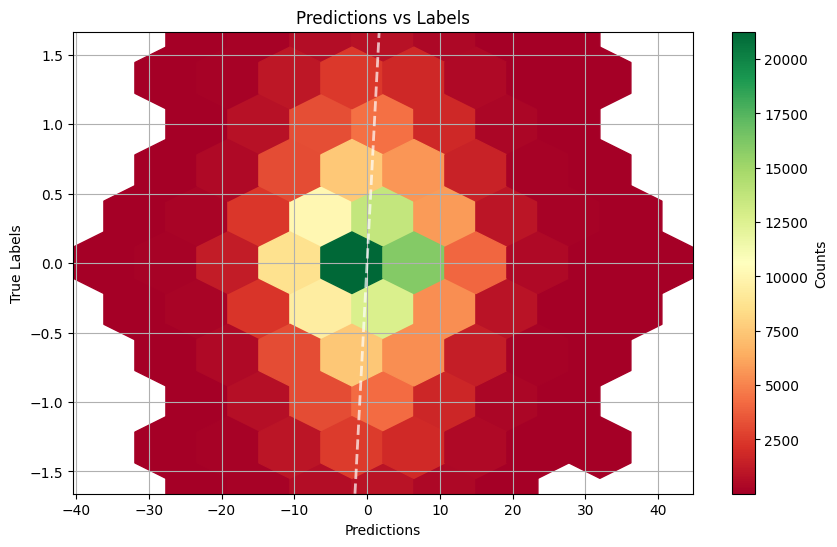

In [29]:
save_path = f"{project_root}/figures/nn_filtered.png"
plots.plot_hexbin_predictions_vs_labels(y_filtered_nn, y_filtered, path=save_path)

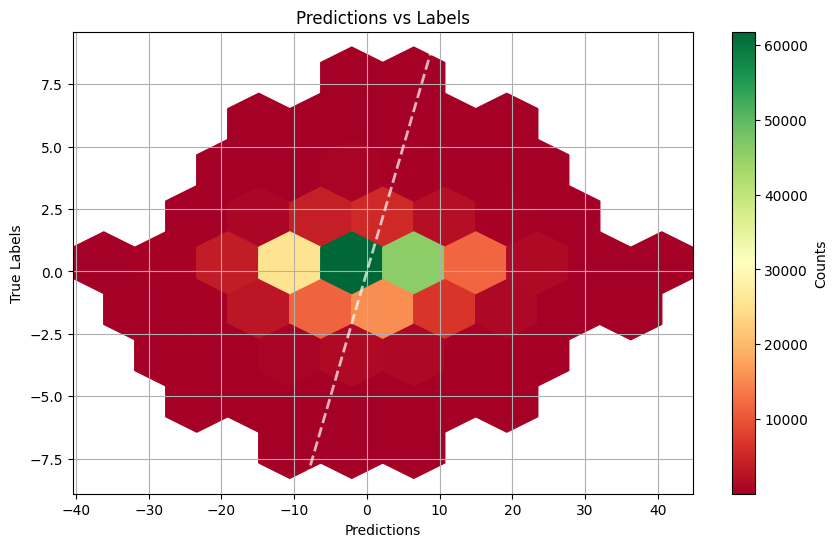

In [30]:
save_path = f"{project_root}/figures/nn_full.png"
plots.plot_hexbin_predictions_vs_labels(y_nn, y_test, path=save_path)

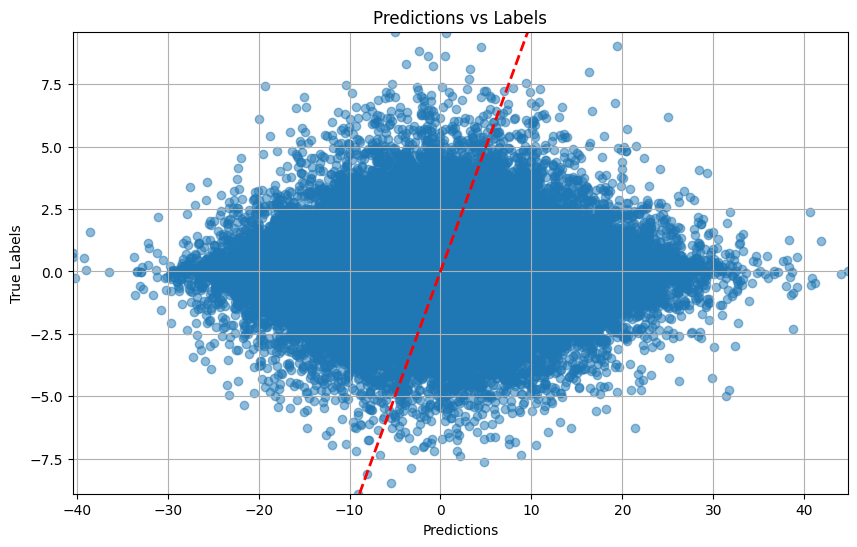

In [31]:
save_path = f"{project_root}/figures/nn_scatter_full.png"
plots.plot_predictions_vs_labels(y_nn, y_test, path=save_path)

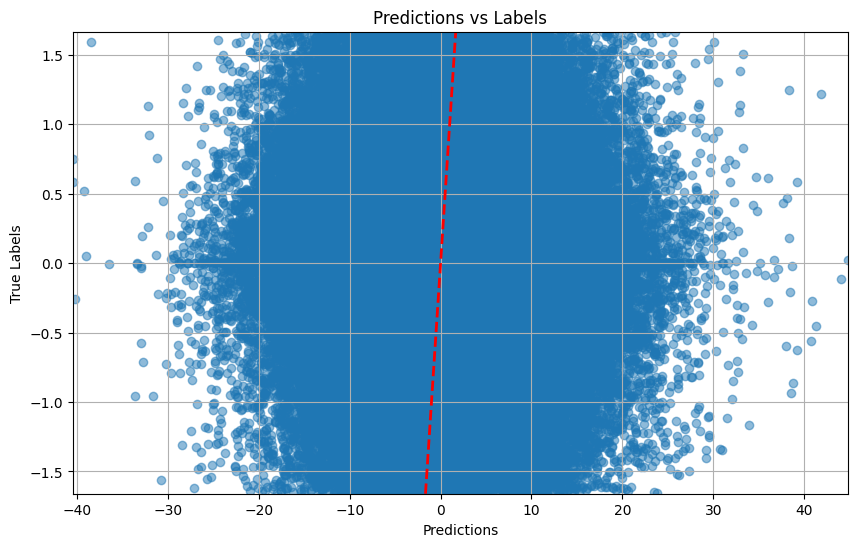

In [32]:
save_path = f"{project_root}/figures/nn_scatter_filtered.png"
plots.plot_predictions_vs_labels(y_filtered_nn, y_filtered, path=save_path)

In [33]:
# could use any of the samplers modulo hyperparameters
# sampler_fns = hmc_fns
# sampler_fns = langevin_fns
sampler_fns = mala_fns


lr = 1e-5
reg = 0.0
lik_var = 0.5
num_samples = 10
init_stddev = 1

In [34]:
# initialization
net_mcmc = hk.transform(net_fn)
key = jax.random.PRNGKey(0)

(
    sampler_init_mcmc,
    sampler_propose_mcmc,
    sampler_accept_mcmc,
    sampler_update_mcmc,
    sampler_get_params_mcmc,
) = sampler_fns(key, num_samples=num_samples, step_size=lr, init_stddev=init_stddev)

params_mcmc = net_mcmc.init(jax.random.PRNGKey(42), x_train[0])
sampler_state_mcmc, sampler_keys_mcmc = sampler_init_mcmc(params_mcmc)
y_initial_mcmc = net_nn.apply(params_mcmc, None, x_test).flatten()
initial_filtered_mcmc = y_initial_mcmc[indices]

In [35]:
def logprob(params, xy):
    """log posterior logP(params | xy), assuming
    P(params) ~ N(0,eta)
    P(y|x, params) ~ N(f(x;params), lik_var)
    """
    x, y = xy
    preds = net_mcmc.apply(params, None, x)
    log_prior = logprior(params, 0.0)
    # log_lik = - jnp.sum(jnp.square(preds - y)) / lik_var
    log_lik = -jnp.sum(jnp.abs(preds - y))
    return log_lik + log_prior

@jax.jit
def sampler_step_mcmc(i, state, keys, batch):
    # print(state)
    # input()
    params = sampler_get_params_mcmc(state)
    logp = lambda params: logprob(params, batch)
    fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

    fx_prop, dx_prop = fx, dx
    # fx_prop, prop_state, dx_prop, new_keys = fx, state, dx, keys
    prop_state, keys = sampler_propose_mcmc(i, dx, state, keys)

    # for RK-langevin and MALA --- recompute gradients
    prop_params = sampler_get_params_mcmc(prop_state)
    fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    # for HMC
    # prop_state, dx_prop, keys = state, dx, keys
    # for j in range(5): #5 iterations of the leapfrog integrator
    # 	prop_state, keys = \
    # 		sampler_propose(i, dx_prop, prop_state, keys)

    # 	prop_params = sampler_get_params(prop_state)
    # 	fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    accept_idxs, keys = sampler_accept_mcmc(
        i, fx, fx_prop, dx, state, dx_prop, prop_state, keys
    )
    state, keys = sampler_update_mcmc(
        i, accept_idxs, dx, state, dx_prop, prop_state, keys
    )

    return state, keys

In [36]:
num_steps = 5
np.random.seed(0)

# do the sampling
for step in trange(num_steps):
    running_loss = 0.0
    for i, xy_train in enumerate(create_batches(x_train, y_train, train_batch_size)):
        sampler_state_mcmc, sampler_keys_mcmc = sampler_step_mcmc(
            step, sampler_state_mcmc, sampler_keys_mcmc, xy_train
        )
        logp = lambda params: logprob(params, xy_train)
        sampler_params_mcmc = sampler_get_params_mcmc(sampler_state_mcmc)
        train_logp = jnp.mean(jax.vmap(logp)(sampler_params_mcmc))
        running_loss += train_logp

    print(f"step = {step + 1}" f" | train logp = {train_logp:.3f}")

sampler_params_mcmc = sampler_get_params_mcmc(sampler_state_mcmc)

 20%|██        | 1/5 [00:24<01:38, 24.56s/it]

step = 1 | train logp = -51353676.000


 40%|████      | 2/5 [00:46<01:09, 23.08s/it]

step = 2 | train logp = -54488008.000


 60%|██████    | 3/5 [01:08<00:44, 22.49s/it]

step = 3 | train logp = -52796624.000


 80%|████████  | 4/5 [01:30<00:22, 22.19s/it]

step = 4 | train logp = -53132328.000


100%|██████████| 5/5 [01:51<00:00, 22.39s/it]

step = 5 | train logp = -51924560.000


In [37]:
y_filtered_mcmc = jax.vmap(net_mcmc.apply, in_axes=(0, None, None))(
    sampler_params_mcmc, None, x_test[indices]
)
y_filtered_mcmc_mean, y_filtered_mcmc_var = y_filtered_mcmc.squeeze(-1).mean(
    0
), y_filtered_mcmc.squeeze(-1).var(0)

y_mcmc = jax.vmap(net_mcmc.apply, in_axes=(0, None, None))(sampler_params_mcmc, None, x_test)
y_mcmc_mean, y_mcmc_var = y_mcmc.squeeze(-1).mean(0), y_mcmc.squeeze(-1).var(0)

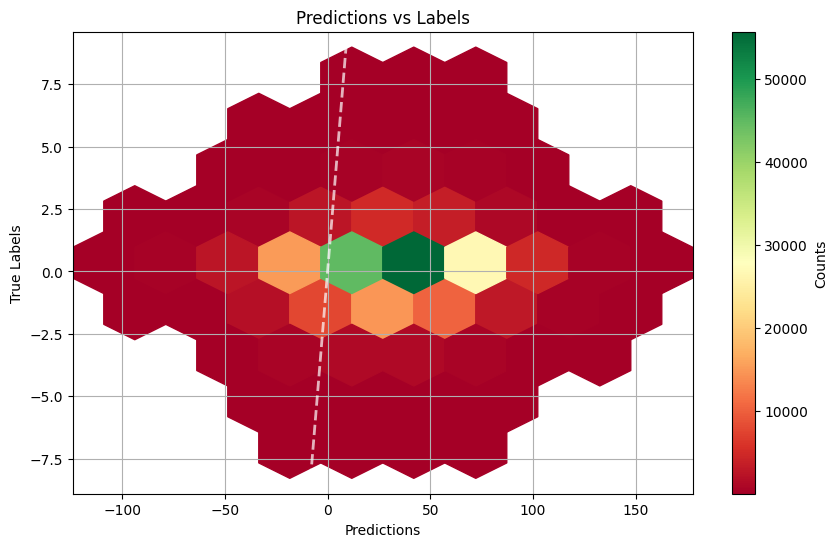

In [38]:
path = f"{project_root}/figures/mcmc_full.png"
plots.plot_hexbin_predictions_vs_labels(y_mcmc_mean, y_test, path=path)

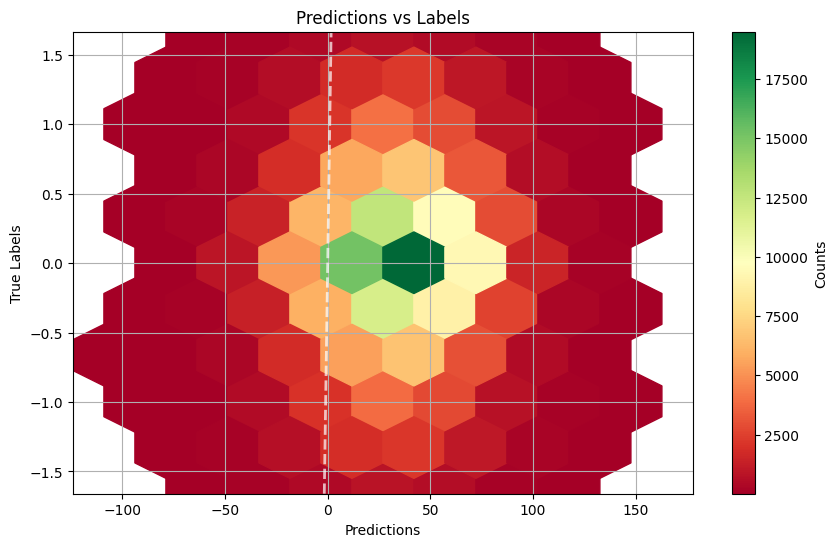

In [39]:
path = f"{project_root}/figures/mcmc_filtered.png"
plots.plot_hexbin_predictions_vs_labels(y_filtered_mcmc_mean, y_filtered, path=path)

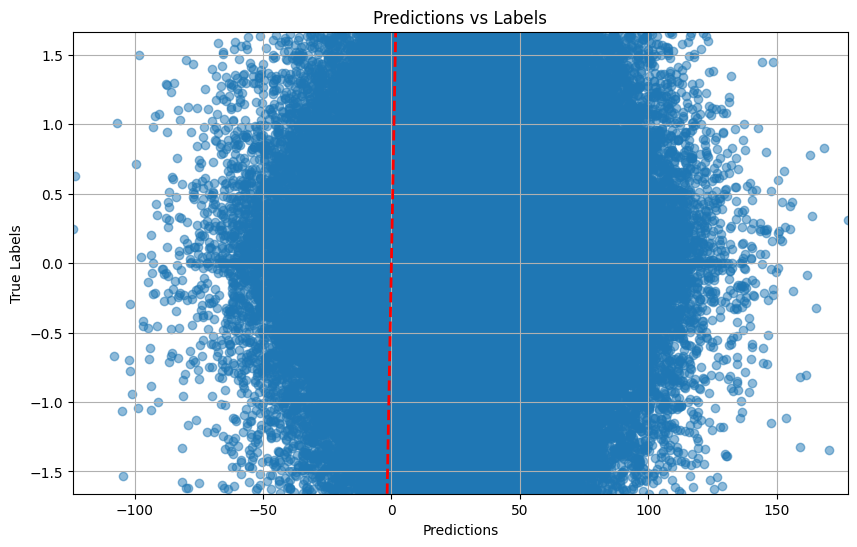

In [40]:
save_path = f"{project_root}/figures/mcmc_scatter_filtered.png"
plots.plot_predictions_vs_labels(y_filtered_mcmc_mean, y_filtered, path=save_path)

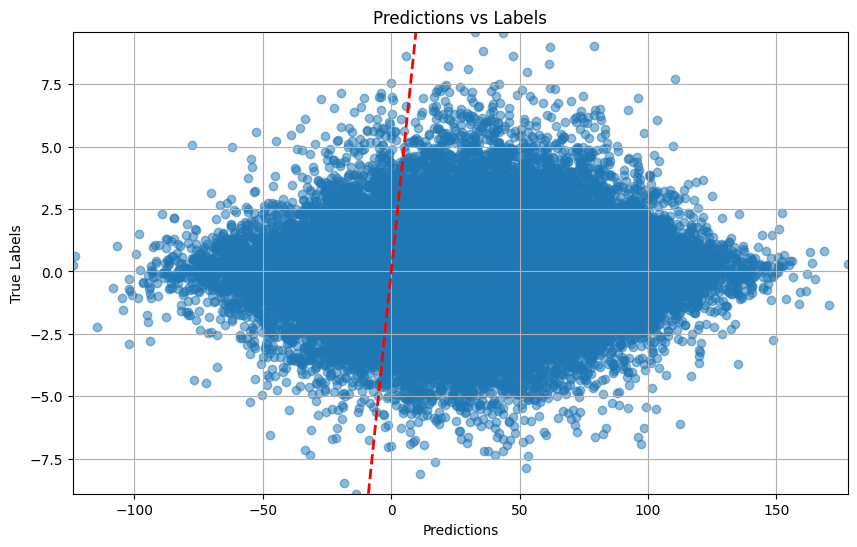

In [41]:
save_path = f"{project_root}/figures/mcmc_scatter_full.png"
plots.plot_predictions_vs_labels(y_mcmc_mean, y_test, path=save_path)

In [42]:
metrics.r2_score(y_filtered_mcmc_mean, y_filtered)

Array(-1.1084738, dtype=float32)

In [43]:
# initialization
sampler_fns = hmc_fns
net_hmc = hk.transform(net_fn)
key = jax.random.PRNGKey(0)

(
    sampler_init_hmc,
    sampler_propose_hmc,
    sampler_accept_hmc,
    sampler_update_hmc,
    sampler_get_params_hmc,
) = sampler_fns(key, num_samples=num_samples, step_size=lr, init_stddev=init_stddev)

params_hmc = net_hmc.init(jax.random.PRNGKey(42), x_train[0])
sampler_state_hmc, sampler_keys_hmc = sampler_init_hmc(params_hmc)

In [44]:
def logprob(params, xy):
    """log posterior logP(params | xy), assuming
    P(params) ~ N(0,eta)
    P(y|x, params) ~ N(f(x;params), lik_var)
    """
    x, y = xy
    preds = net_hmc.apply(params, None, x)
    log_prior = logprior(params, 0.0)
    #log_lik = - jnp.sum(jnp.square(preds - y)) / lik_var
    log_lik = -jnp.sum(jnp.abs(preds - y))
    return log_lik + log_prior

@jax.jit
def sampler_step_hmc(i, state, keys, batch):
    # print(state)
    # input()
    params = sampler_get_params_hmc(state)
    logp = lambda params: logprob(params, batch)
    fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

    fx_prop, dx_prop = fx, dx
    # fx_prop, prop_state, dx_prop, new_keys = fx, state, dx, keys
    prop_state, keys = sampler_propose_hmc(i, dx, state, keys)

    # for HMC
    prop_state, dx_prop, keys = state, dx, keys
    for j in range(5):
        prop_state, keys = sampler_propose_hmc(i, dx_prop, prop_state, keys)

        prop_params = sampler_get_params_hmc(prop_state)
        fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    accept_idxs, keys = sampler_accept_hmc(
        i, fx, fx_prop, dx, state, dx_prop, prop_state, keys
    )
    state, keys = sampler_update_hmc(
        i, accept_idxs, dx, state, dx_prop, prop_state, keys
    )

    return state, keys

In [45]:
num_steps = 5

# do the sampling
for step in trange(num_steps):
    running_loss = 0.0
    for i, xy_train in enumerate(create_batches(x_train, y_train, train_batch_size)):
        sampler_state_hmc, sampler_keys_hmc = sampler_step_hmc(
            step, sampler_state_hmc, sampler_keys_hmc, xy_train
        )
        logp = lambda params: logprob(params, xy_train)
        sampler_params_hmc = sampler_get_params_hmc(sampler_state_hmc)
        train_logp = jnp.mean(jax.vmap(logp)(sampler_params_hmc))
        running_loss += train_logp

    print(f"step = {step + 1}" f" | train logp = {train_logp:.3f}")

sampler_params_hmc = sampler_get_params_hmc(sampler_state_hmc)

 20%|██        | 1/5 [00:29<01:56, 29.07s/it]

step = 1 | train logp = -17982878.000


 40%|████      | 2/5 [00:58<01:27, 29.09s/it]

step = 2 | train logp = -9067578.000


 60%|██████    | 3/5 [01:26<00:57, 28.62s/it]

step = 3 | train logp = -3751801.250


 80%|████████  | 4/5 [01:53<00:28, 28.24s/it]

step = 4 | train logp = -1398801.875


100%|██████████| 5/5 [02:24<00:00, 28.90s/it]

step = 5 | train logp = -740751.312


In [46]:
y_filtered_hmc = jax.vmap(net_hmc.apply, in_axes=(0, None, None))(
    sampler_params_hmc, None, x_test[indices]
)
y_filtered_hmc_mean, y_filtered_hmc_var = y_filtered_hmc.squeeze(-1).mean(
    0
), y_filtered_hmc.squeeze(-1).var(0)

y_hmc = jax.vmap(net_hmc.apply, in_axes=(0, None, None))(sampler_params_hmc, None, x_test)
y_hmc_mean, y_hmc_var = y_hmc.squeeze(-1).mean(0), y_hmc.squeeze(-1).var(0)

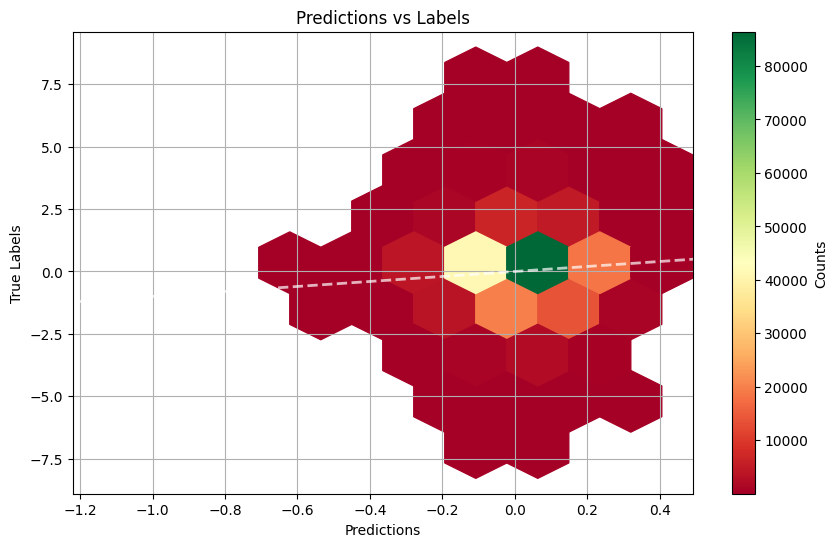

In [47]:
path = f"{project_root}/figures/hmc_full.png"
plots.plot_hexbin_predictions_vs_labels(y_hmc_mean, y_test, path=path)

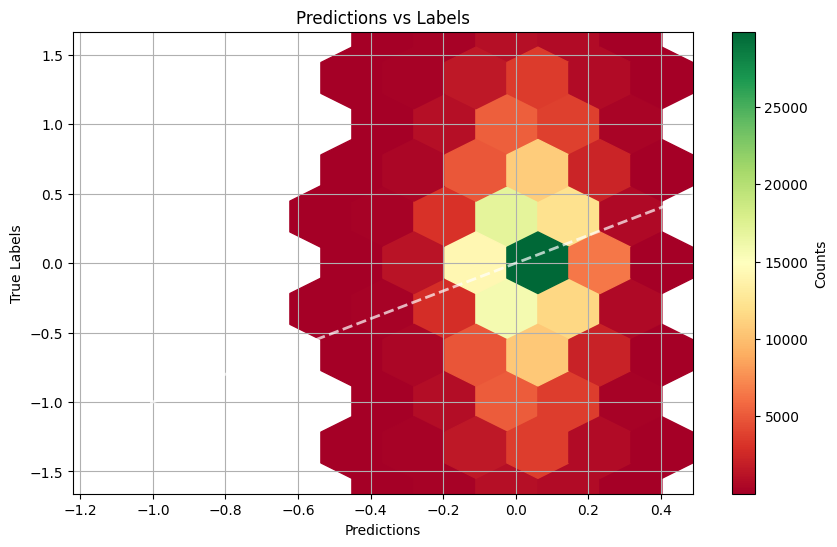

In [48]:
path = f"{project_root}/figures/hmc_filtered.png"
plots.plot_hexbin_predictions_vs_labels(y_filtered_hmc_mean, y_filtered, path=path)

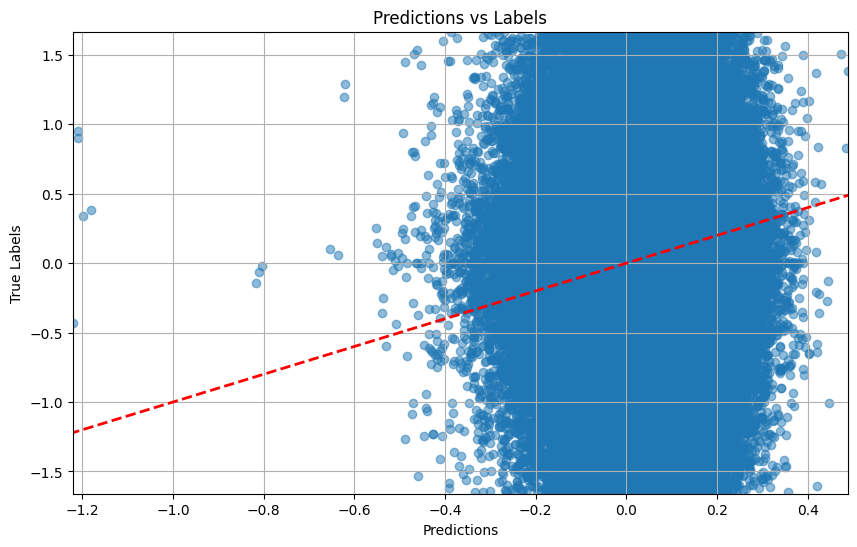

In [49]:
save_path = f"{project_root}/figures/hmc_scatter_filtered.png"
plots.plot_predictions_vs_labels(y_filtered_hmc_mean, y_filtered, path=save_path)

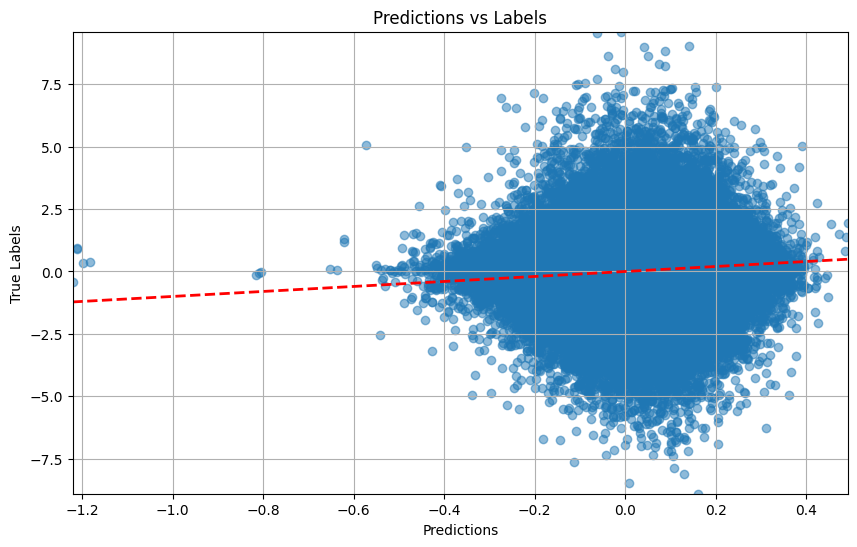

In [50]:
save_path = f"{project_root}/figures/hmc_scatter_full.png"
plots.plot_predictions_vs_labels(y_hmc_mean, y_test, path=save_path)

In [59]:
metrics.r2_score(y_hmc_mean, y_test)

Array(-85.11196, dtype=float32)

## Count Data Regression

## Deep Kernel Learning